# Optimization

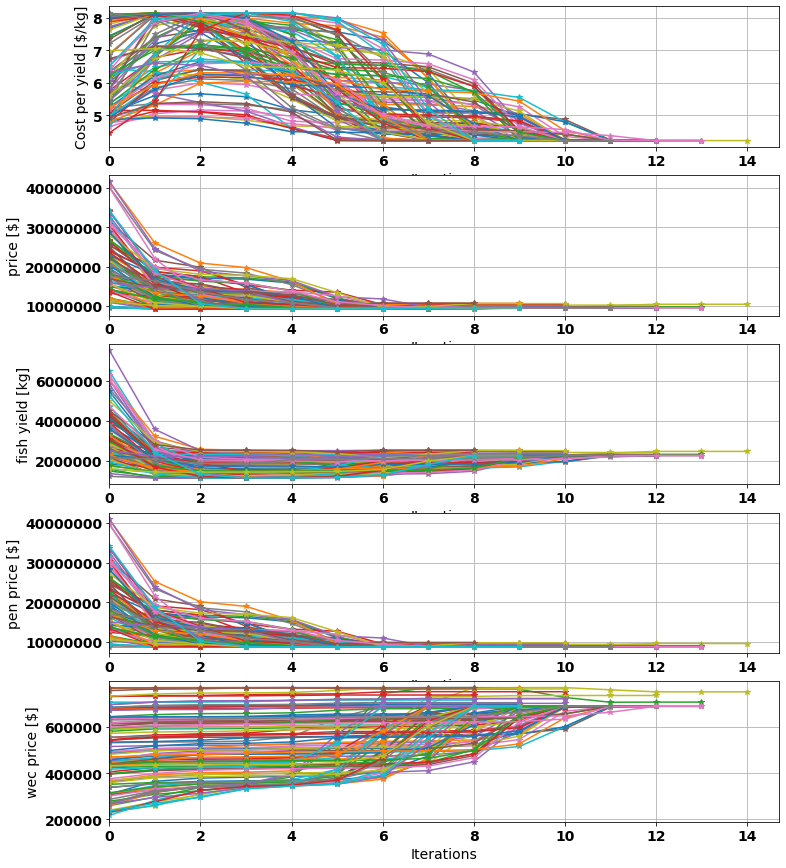

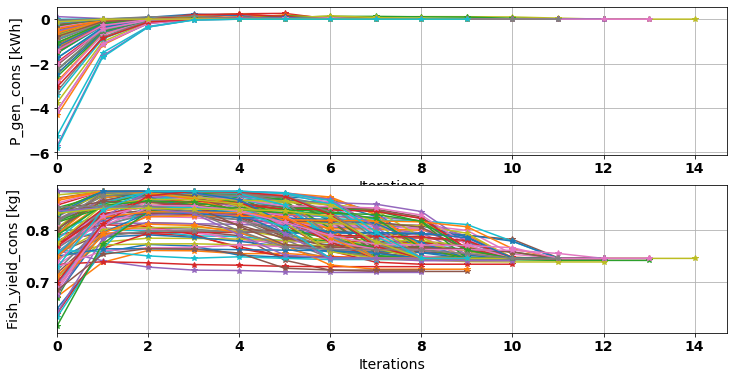

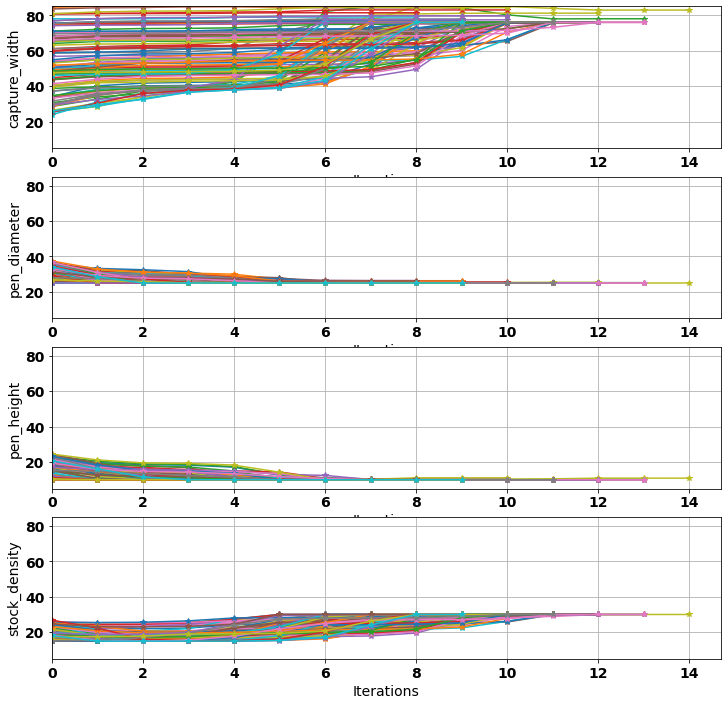

True
optimal design variable:
   capture_width      76.050 [m]
   pen_diameter       25.000 [m]
   pen_height         10.000 [m]
   stock_density      30.000 [kg/m^3]
----------------------------------------
optimal objective function terms:
   cost_per_yield      4.228 [$/kg]
   price          9525870.630 [$]
   fish_yield     2253110.981 [kg]
----------------------------------------
optimal constraints:
   normalized P_gen_cons               -0.000 [-]
   normalized fish_yield_cons           0.746 [-]
   normalized pen_ratio_low_cons        0.600 [-]
   normalized pen_ratio_up_cons         0.167 [-]
----------------------------------------


In [37]:
import modules
import optimization
import numpy as np
import importlib
importlib.reload(modules)
from matplotlib import pyplot as plt
from matplotlib.ticker import FormatStrFormatter
import pandas as pd
from math import pi

max_iter = 10000
test_iter = 100

def print_bold(str):
    print('\033[1m' + str + '\033[0;0m')
    return

def print_objective(x0, x_name, p):
    cost_per_yield, price, fish_yield, _, _ = modules.obj_terms(x0, x_name, p)
    print(' '*2, "cost_per_yield", "{:10.3f}".format(cost_per_yield), '[$/kg]')
    print(' '*2, "price         ", "{:10.3f}".format(price), '[$]')
    print(' '*2, "fish_yield    ", "{:10.3f}".format(fish_yield), '[kg]')

def print_ineq_cons(x0, x_name, p):
    print(' '*2, "normalized P_gen_cons          ", "{:10.3f}".format(modules.ineq_constraint(x0, x_name, p)[0]), '[-]')
    print(' '*2, "normalized fish_yield_cons     ", "{:10.3f}".format(modules.ineq_constraint(x0, x_name, p)[1]), '[-]')
    print(' '*2, "normalized pen_ratio_low_cons  ", "{:10.3f}".format(modules.ineq_constraint(x0, x_name, p)[2]), '[-]')
    print(' '*2, "normalized pen_ratio_up_cons   ", "{:10.3f}".format(modules.ineq_constraint(x0, x_name, p)[3]), '[-]')
            
def optimize_result(x_name, x_list, x_unit, res, p, opt_idx):
    col_width = len(max(x_list, key=len))
    print(res[opt_idx].success)
    print_bold("optimal design variable:")
    for i in range(len(x_list)):
        print(' '*2, x_list[i], ' '*(col_width - len(x_list[i])) , "{:10.3f}".format(res[opt_idx].x[i]), x_unit[i])
    print("-"*40)

    print_bold("optimal objective function terms:")
    print_objective(res[opt_idx].x, x_name, p)
    print("-"*40)
    
    print_bold("optimal constraints:")
    print_ineq_cons(res[opt_idx].x, x_name, p)
    print("-"*40)
    
    
# fill default parameters
all_vars = ['x_wec','x_type_wec','x_pen','p_pen','x_env','p_env','p_wec','p_fish_salmon']

wec_types = ['point absorber'] #,'attenuator','terminator','point absorber']

# design variables
x_name = ['x_wec','x_pen']
x_list, x0_val, x_unit, x_bnds, x_label = optimization.default_value(x_name)
x0 = []
for i in range(len(x_list)):
    x0.append(x0_val[x_list[i]])

# parameters
param_name = ['x_type_wec']
param_val = {}

#optimization
best_idx = 0
res={}

#fig for obj func
plot_no = 5
plot_title = ['Cost per yield [$/kg]', 'price [$]', 'fish yield [kg]', 'pen price [$]', 'wec price [$]']
fig, ax = plt.subplots(plot_no,1, figsize=(12, plot_no*3))
ax[0] = plt.subplot(plot_no,1,1)
ax[1] = plt.subplot(plot_no,1,2)
ax[2] = plt.subplot(plot_no,1,3)
ax[3] = plt.subplot(plot_no,1,4)
ax[4] = plt.subplot(plot_no,1,5)
#fig for constraints
cons_no = 2
cons_title = ['P_gen_cons [kWh]', 'Fish_yield_cons [kg]']
fig_cons, ax_cons = plt.subplots(2,1, figsize=(12, cons_no*3))
ax_cons[0] = plt.subplot(cons_no,1,1)
ax_cons[1] = plt.subplot(cons_no,1,2)
#fig for design var
fig_x, ax_x = plt.subplots(len(x_list),1, figsize=(12, 4*3))
for ii in range(len(x_list)):
    ax_x[ii] = plt.subplot(len(x_list),1,ii+1)


opt_res_history = []
cons_history = []
iteration_history = []
data_history = np.empty([test_iter,len(x0)+1+4]) #design_var + obj + cons
for i in range(len(wec_types)):
    param_val['wec_type'] = wec_types[i]
    p_list, p, p_unit, p_bnds, p_label = optimization.argument_fun(x_name, param_name, param_val, all_vars)
    
    iteration = np.arange(1,max_iter+1,1)
    
    for n_test in range(test_iter):
        x0 = []
        for i0 in range(len(x_bnds)):
            x0.append(np.random.uniform(low=x_bnds[i0][0], high=x_bnds[i0][1]))
    
        res[i], op_obj = optimization.run_optimization(x_name, x0, param_name, param_val, all_vars, max_iter)
    

        if res[i].fun < res[best_idx].fun:
            best_idx = i
        
        #ax.plot(iteration, op_obj.f)
        
        ax[0].plot(op_obj.obj_history[:, 0], marker='*')      
        ax[1].plot(op_obj.obj_history[:, 1], marker='*')
        ax[2].plot(op_obj.obj_history[:, 2], marker='*')
        ax[3].plot(op_obj.obj_history[:, 3], marker='*')
        ax[4].plot(op_obj.obj_history[:, 4], marker='*')
        ax_cons[0].plot(op_obj.ineq[:, 0], marker='*')
        ax_cons[1].plot(op_obj.ineq[:, 1], marker='*')
        for ii in range(len(x_list)):
            ax_x[ii].plot(op_obj.x_history[:, ii], marker='*')
        
        opt_res_history.append(op_obj.f)
        iteration_history.append(op_obj.count)
        cons_history.append(op_obj.ineq)
        
        if res[i].success:
            data_history[n_test] = np.concatenate((np.array([res[i].fun]), np.round(np.array(res[i].x), decimals = 3), np.array(op_obj.ineq[op_obj.count-1,:])), axis=0)

for i in range(plot_no):
    ax[i].set(xlabel='Iterations', ylabel=plot_title[i])
    ax[i].grid(True)
    ax[i].set_xlim(0, None)
    ax[i].ticklabel_format(useOffset=False, style='plain', axis='y')
for i in range(cons_no):
    ax_cons[i].set(xlabel='Iterations', ylabel=cons_title[i])
    ax_cons[i].grid(True)
    ax_cons[i].set_xlim(0, None)
    ax_cons[i].ticklabel_format(useOffset=False, style='plain', axis='y')
for i in range(len(x_list)):
    ax_x[i].set(xlabel='Iterations', ylabel=x_list[i])
    ax_x[i].grid(True)
    ax_x[i].set_xlim(0, None)
    ax_x[i].set_ylim(5, 85)
    ax_x[i].ticklabel_format(useOffset=False, style='plain', axis='y')
plt.show()

df = pd.DataFrame (data_history)
df = df.set_axis(['Obj', 'capture_width', 'pen_diameter', 'pen_height', 'stock_density', 'P_gen_cons', 'fish_yield_cons', 'pen_ratio_low_cons', 'pen_ratio_up_cons'], axis=1)
#save data to xlsx format
filepath = 'results/design_var_raninit.xlsx'
df.to_excel(filepath, index=False)

optimize_result(x_name, x_list, x_unit, res, p, best_idx)

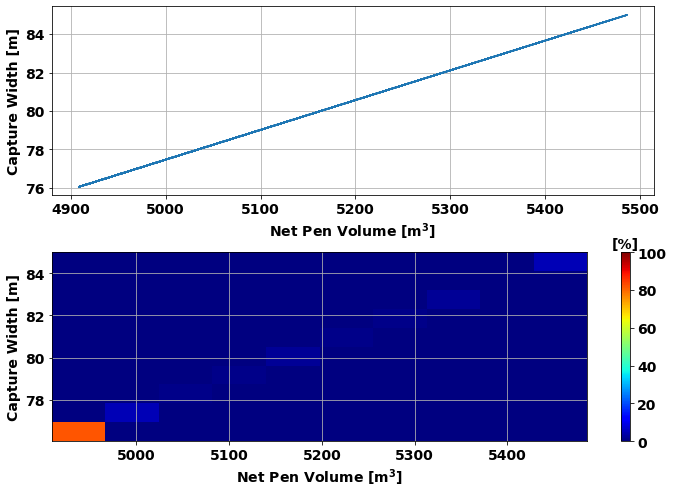

In [38]:
volume = pi * df.pen_height * df.pen_diameter**2 * 0.25

fig, ax = plt.subplots(2,1, figsize=(12, 8))

fs = 14
font = {'weight': 'bold',
        'size': fs} 

ax1 = plt.subplot(211)
plt.xlabel('Net Pen Volume [m$^3$]', fontsize = fs, fontweight = 'bold')
plt.ylabel('Capture Width [m]', fontsize = fs, fontweight = 'bold')
ax1.grid()

ax2 = plt.subplot(212)
plt.hist2d(volume, df.capture_width, vmin=0, vmax=100, cmap=plt.cm.jet, bins = 10)
cbar = plt.colorbar()
cbar.ax.set_xlabel('[%]', fontsize = fs, fontweight = 'bold')
cbar.ax.xaxis.set_label_position('top') 
plt.xlabel('Net Pen Volume [m$^3$]', fontsize = fs, fontweight = 'bold')
plt.ylabel('Capture Width [m]', fontsize = fs, fontweight = 'bold')
ax2.grid()

plt.rc('font', **font)
plt.subplots_adjust(hspace=0.3)

ax1.plot(volume, df.capture_width)
pos1 = ax1.get_position() # get the original position 
pos2 = [pos1.x0, pos1.y0,  pos1.width * .9, pos1.height]
ax1.set_position(pos2) # set a new position

plt.savefig('results/random_init.pdf')
plt.savefig('results/random_init.png')
#plt.show()

In [43]:
# ref: https://plotly.com/python/parallel-coordinates-plot/
import plotly.graph_objects as go

import pandas as pd

df['run_id'] = np.random.randn(len(df))

fig = go.Figure(data=
    go.Parcoords(
        line = dict(color = df['run_id'],
                   colorscale = [[0,'white'],[1,'black']],
                                                                     ),
        dimensions = list([
            dict(range = [70,90],
                tickvals = np.linspace(70,90, 5),
                label = 'Capture Width [m]', values = df['capture_width']),
            dict(range = [22,30],
            tickvals = np.linspace(22,30, 5),
                label = 'Pen Diameter [m]', values = df['pen_diameter']),
            dict(range = [8,12],
                tickvals = np.linspace(8,12, 5),
                label = 'Pen Height [m]', values = df['pen_height']),
            dict(range = [28,32],
                tickvals = np.linspace(28,32, 5),
                label = 'Stocking Density [kg/m^3]', values = df['stock_density']),
            dict(range = [4,4.8],
                tickvals = np.linspace(4,4.8, 5),
                label = 'Cost / Fish Yield [$/kg]', values = df['Obj']),
            dict(range = [0,1],
                tickvals = np.linspace(0,1, 5),
                label = 'Norm. Power Supply [-]', values = df['P_gen_cons']),
            dict(range = [0,1],
                tickvals = np.linspace(0,1, 5),
                label = 'Norm. Fish Yield [-]', values = df['fish_yield_cons'])
        ])
    )
)

fs = 14
fig.update_traces(
    labelfont=
    dict(size= fs), 
    tickfont=dict(size= fs), 
    selector=dict(type='parcoords')
    ) 

fig.update_layout(
    plot_bgcolor = 'white',
    paper_bgcolor = 'white',
    autosize=False,
    width=1350,
    height=500
    )

fig.write_image("results/Parallel_coordinate.pdf")
fig.write_image("results/Parallel_coordinate.png")
fig.show()